# SETTING UP THE ENV

Lets impot Libraries

In [1]:
#download necessary libraries

!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.6 MB/s eta 0:00:00


In [2]:
import sys
sys.path.append('/kaggle/working')
# !ls /kaggle/working
import torch
print(torch.__version__)
print(torch.version.cuda)

2.1.2
12.1


In [3]:
from typing import Union, Tuple
from torch_geometric.typing import OptPairTensor, Adj, Size # Optional[Tensor], Union[Tensor, SparseTensor], Optional[Tuple[int, int]], all about data type

from torch import Tensor
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn.conv import MessagePassing

In [4]:
import warnings
warnings.filterwarnings("ignore")
import os
import time
import random
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from joblib import Parallel, delayed

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
import torch_geometric.nn as gnn
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Dataset, Data, DataLoader
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.utils import softmax
from sklearn.metrics import r2_score

# Pre Processing

In [5]:
df = pd.read_csv('/kaggle/input/cms-dataset/CMS_trigger.csv')
print(df.columns)

Index(['Unnamed: 0', 'Phi_0', 'Phi_2', 'Phi_3', 'Phi_4', 'Theta_0', 'Theta_2',
       'Theta_3', 'Theta_4', 'BendingAngle_0', 'BendingAngle_2',
       'BendingAngle_3', 'BendingAngle_4', 'TimeInfo_0', 'TimeInfo_2',
       'TimeInfo_3', 'TimeInfo_4', 'RingNumber_0', 'RingNumber_2',
       'RingNumber_3', 'RingNumber_4', 'Front_0', 'Front_2', 'Front_3',
       'Front_4', 'Mask_0', 'Mask_2', 'Mask_3', 'Mask_4',
       'PatternStraightness', 'Zone', 'MedianTheta', 'q/pt', 'PhiAngle',
       'EtaAngle'],
      dtype='object')


In [6]:
df.head()

,Unnamed: 0,Phi_0,Phi_2,Phi_3,Phi_4,Theta_0,Theta_2,Theta_3,Theta_4,BendingAngle_0,...,Mask_0,Mask_2,Mask_3,Mask_4,PatternStraightness,Zone,MedianTheta,q/pt,PhiAngle,EtaAngle
0,0,58.066666,55.466667,55.466667,56.000000,11.970,11.684999,11.400,11.400,-13.000000,...,0.0,0.0,0.0,0.0,5.0,3.0,105.0,0.181209,-3.075936,1.722345
1,1,64.583336,66.800000,67.066666,67.200000,6.555,6.840000,6.555,6.840,7.000000,...,0.0,0.0,0.0,0.0,3.0,1.0,124.0,-0.146131,-0.167139,2.012122
2,2,71.150000,67.033330,66.266670,65.466670,2.850,2.565000,2.280,2.280,-16.613783,...,0.0,0.0,0.0,0.0,7.0,0.0,127.0,0.367024,2.431823,2.321646
3,3,34.933334,31.200000,31.200000,31.833334,9.690,8.835000,8.835,9.120,-13.000000,...,0.0,0.0,0.0,0.0,6.0,2.0,60.0,0.267774,-1.343305,1.854506
4,4,68.150000,68.266670,68.300000,68.400000,2.565,2.565000,2.565,2.565,0.000000,...,0.0,0.0,0.0,0.0,4.0,0.0,128.0,-0.019179,-3.134433,2.333772


In [7]:
df.describe()

,Unnamed: 0,Phi_0,Phi_2,Phi_3,Phi_4,Theta_0,Theta_2,Theta_3,Theta_4,BendingAngle_0,...,Mask_0,Mask_2,Mask_3,Mask_4,PatternStraightness,Zone,MedianTheta,q/pt,PhiAngle,EtaAngle
count,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,...,1179356.0,1179356.0,1179356.0,1179356.0,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06
mean,5.896775e+05,4.851559e+01,4.851127e+01,4.851076e+01,4.851331e+01,6.195453e+00,5.918753e+00,5.848332e+00,5.881490e+00,5.603115e-02,...,0.0,0.0,0.0,0.0,3.976490e+00,1.080514e+00,9.115961e+01,5.540485e-04,8.881380e-04,8.762006e-04
std,3.404509e+05,1.774647e+01,1.779697e+01,1.781670e+01,1.779750e+01,3.011983e+00,2.921076e+00,2.911875e+00,2.906416e+00,1.493805e+01,...,0.0,0.0,0.0,0.0,1.871622e+00,1.089190e+00,3.328909e+01,2.524173e-01,1.820920e+00,2.075298e+00
min,0.000000e+00,1.103333e+01,2.400000e+00,2.666667e+00,2.666667e+00,1.425000e+00,1.425000e+00,1.425000e+00,1.710000e+00,-1.329103e+02,...,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,8.000000e+00,-4.999928e-01,-3.141584e+00,-2.499009e+00
25%,2.948388e+05,3.371667e+01,3.360000e+01,3.360000e+01,3.360000e+01,3.705000e+00,3.420000e+00,3.420000e+00,3.420000e+00,-1.100000e+01,...,0.0,0.0,0.0,0.0,3.000000e+00,0.000000e+00,6.300000e+01,-2.055347e-01,-1.584667e+00,-2.074832e+00
50%,5.896775e+05,4.830000e+01,4.826667e+01,4.826667e+01,4.826667e+01,5.700000e+00,5.415000e+00,5.415000e+00,5.415000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,4.000000e+00,1.000000e+00,9.100000e+01,2.155910e-04,8.142424e-03,1.523139e+00
75%,8.845162e+05,6.326667e+01,6.303333e+01,6.293333e+01,6.296667e+01,8.265000e+00,7.980000e+00,7.695000e+00,7.980000e+00,1.100000e+01,...,0.0,0.0,0.0,0.0,5.000000e+00,2.000000e+00,1.180000e+02,2.069167e-01,1.581958e+00,2.074729e+00
max,1.179355e+06,8.311667e+01,8.256667e+01,8.253333e+01,8.253333e+01,1.510500e+01,1.396500e+01,1.539000e+01,1.510500e+01,1.421401e+02,...,0.0,0.0,0.0,0.0,8.000000e+00,4.000000e+00,1.540000e+02,4.999991e-01,3.141592e+00,2.493834e+00


In [8]:
#HOW MOMENTUM NEGATIVE??

**The data is not scaled, so we would have to scale the data first before we proceed to train a model on the data**

**To begin with lets  scale the data by using Standard Scalar**

In [9]:
scaler = StandardScaler()

In [10]:
df.loc[:,"Phi_0":"MedianTheta"] = scaler.fit_transform(df.loc[:,"Phi_0":"MedianTheta"])

In [11]:
df.describe()

,Unnamed: 0,Phi_0,Phi_2,Phi_3,Phi_4,Theta_0,Theta_2,Theta_3,Theta_4,BendingAngle_0,...,Mask_0,Mask_2,Mask_3,Mask_4,PatternStraightness,Zone,MedianTheta,q/pt,PhiAngle,EtaAngle
count,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,...,1179356.0,1179356.0,1179356.0,1179356.0,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06
mean,5.896775e+05,7.146661e-17,-2.706296e-16,-7.705465e-16,-3.355171e-16,-2.781065e-16,8.641905e-16,6.533453e-16,3.205695e-16,2.842518e-17,...,0.0,0.0,0.0,0.0,-4.221603e-17,-8.916758e-18,1.504040e-16,5.540485e-04,8.881380e-04,8.762006e-04
std,3.404509e+05,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,0.0,0.0,0.0,0.0,1.000000e+00,1.000000e+00,1.000000e+00,2.524173e-01,1.820920e+00,2.075298e+00
min,0.000000e+00,-2.112098e+00,-2.590963e+00,-2.573098e+00,-2.576017e+00,-1.583825e+00,-1.538390e+00,-1.519067e+00,-1.435270e+00,-8.901182e+00,...,0.0,0.0,0.0,0.0,-2.124623e+00,-9.920352e-01,-2.498105e+00,-4.999928e-01,-3.141584e+00,-2.499009e+00
25%,2.948388e+05,-8.339083e-01,-8.378547e-01,-8.368982e-01,-8.379445e-01,-8.268486e-01,-8.554224e-01,-8.339413e-01,-8.469162e-01,-7.401255e-01,...,0.0,0.0,0.0,0.0,-5.217347e-01,-9.920352e-01,-8.459116e-01,-2.055347e-01,-1.584667e+00,-2.074832e+00
50%,5.896775e+05,-1.214813e-02,-1.374387e-02,-1.370004e-02,-1.385850e-02,-1.644940e-01,-1.724547e-01,-1.488154e-01,-1.605036e-01,-3.750902e-03,...,0.0,0.0,0.0,0.0,1.256146e-02,-7.392128e-02,-4.794768e-03,2.155910e-04,8.142424e-03,1.523139e+00
75%,8.845162e+05,8.312126e-01,8.159859e-01,8.094982e-01,8.121005e-01,6.871047e-01,7.056466e-01,6.341855e-01,7.220270e-01,7.326237e-01,...,0.0,0.0,0.0,0.0,5.468577e-01,8.441926e-01,8.062822e-01,2.069167e-01,1.581958e+00,2.074729e+00
max,1.179355e+06,1.949746e+00,1.913552e+00,1.909590e+00,1.911506e+00,2.958035e+00,2.754550e+00,3.276814e+00,3.173501e+00,9.511558e+00,...,0.0,0.0,0.0,0.0,2.149746e+00,2.680420e+00,1.887718e+00,4.999991e-01,3.141592e+00,2.493834e+00


**We can see that the std dev and the mean has been transformed to 1 and 0 respectively**

In [12]:
features = list(df.columns)[1:29]
features

['Phi_0',
 'Phi_2',
 'Phi_3',
 'Phi_4',
 'Theta_0',
 'Theta_2',
 'Theta_3',
 'Theta_4',
 'BendingAngle_0',
 'BendingAngle_2',
 'BendingAngle_3',
 'BendingAngle_4',
 'TimeInfo_0',
 'TimeInfo_2',
 'TimeInfo_3',
 'TimeInfo_4',
 'RingNumber_0',
 'RingNumber_2',
 'RingNumber_3',
 'RingNumber_4',
 'Front_0',
 'Front_2',
 'Front_3',
 'Front_4',
 'Mask_0',
 'Mask_2',
 'Mask_3',
 'Mask_4']

In [13]:
# Lets split the data into train and the test splits

In [14]:
train_idx, test_idx = train_test_split(df['Unnamed: 0'].to_numpy(), test_size = 0.2, random_state = 1)
x_data = df[features].to_numpy()
pT = abs(1/df.loc[:,'q/pt']).to_numpy()
label = pT
num_features = x_data.shape[-1]
print('Data shape: ' + str(x_data.shape))
print(pT.shape)
print('Len train: '+str(len(train_idx))+', Len test: '+str(len(test_idx)))
print('Num. features: '+str(num_features))

Data shape: (1179356, 28)
(1179356,)
Len train: 943484, Len test: 235872
Num. features: 28


In [15]:
label.min(), label.max()

(2.00000380000722, 6955.5709428241635)

# Dataset Class and Data Loaders

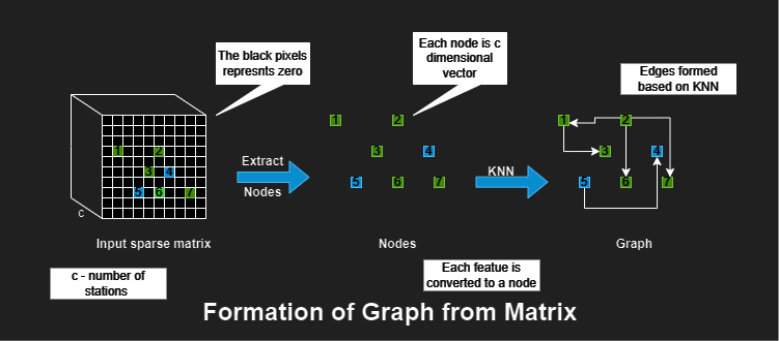

**The dataset is having 28 features extracted from 4 triggers ie 7 features per trigger**

**Total approached to try**

---------------------------------------------------------------------------------------------------------------------------

- [ ] **Each station as a node : 
    Here basically each station(4),is made a node of the graph and the node feature is the features recieved at the respective station(7)**
    
    Here,
         Total nodes = 4
         node feature length = 7
         edges should be between these 4 nodes (Yet to find out the best way to decide across which two nodes there should be and edge)
    
    
---------------------------------------------------------------------------------------------------------------------------
**(THIS NOTEBOOK)**
- [x] **Each feature as a node :
    Here basically each feature obtianed from different stations, here 4 stations are made a node of the graph and 
    the node feature is the values of this feature across the 4 different stations**
    
    Here,
         Total nodes = 7
         node feature length = 4
         edges should be between these 7 nodes (Yet to find out the best way to decide across which two nodes there should be and edge)
         
---------------------------------------------------------------------------------------------------------------------------

- [ ]  **Each patch as a node :
    Here basically the data is converted into 7*4 matrix and then would have to split this into patches and then the features of the noden would be the flattened pixel values in each patch**
    
    Here,
         Total nodes = total_patches 
         node feature length = pixels in each path
         edges should be between these patch nodes (Yet to find out the best way to decide across which two nodes there should be and edge
         
---------------------------------------------------------------------------------------------------------------------------

In [16]:
# x_data.shape

In [17]:
class Graph_dataset(Dataset):
    def __init__(self, dataset , label,  edge_index, indices, transform=None):
        self.transform = transform
        self.data = dataset
        self.edge_index = edge_index
        self.indices = indices
        self.label = label
    
    def __getitem__(self, idx):
        return self.convert_to_graph(self.indices[idx])
    
    def __len__(self):
        return len(self.indices)
    
    def convert_to_graph(self, i):
    
        data = Data(x=torch.tensor(self.data[i].reshape(-1,7).T, dtype=torch.float), y=torch.tensor(self.label[i], dtype=torch.float),
                    edge_index=torch.tensor(self.edge_index, dtype = torch.long).T)
        return data

In [18]:
edge_index = [(0,1),(1,2),(2,3),(3,2),(2,1),(1,0),(0,2),(2,0),(2,4),(2,5),(2,6),(4,2),(5,2),(6,2)]

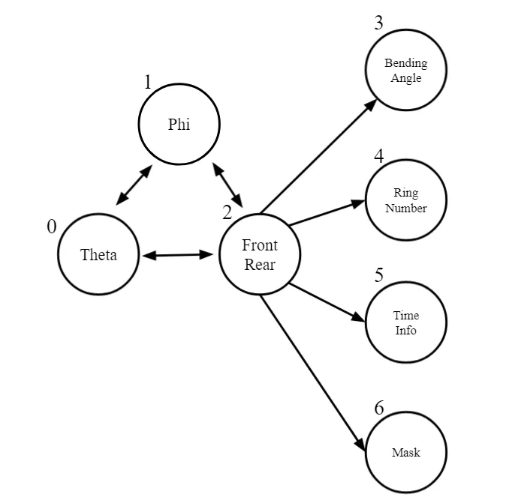

In [19]:
train_dataset = Graph_dataset(x_data, label, edge_index , train_idx)
next(iter(train_dataset))

Data(x=[7, 4], edge_index=[2, 14], y=9.726032257080078)

In [20]:
train_loader = DataLoader(Graph_dataset(x_data, label, edge_index , train_idx), batch_size=1024)
test_loader = DataLoader(Graph_dataset(x_data, label, edge_index , test_idx), batch_size=512)

In [21]:
next(iter(train_loader))

DataBatch(x=[7168, 4], edge_index=[2, 14336], y=[1024], batch=[7168], ptr=[1025])

**We are all set with the dataset and the dataloader**

# Lets set the Model

In [22]:
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from torch_geometric.utils import to_dense_batch
import torch
import torch.nn as nn
import torch.nn.functional as F

In [23]:
class MODEL_GNN(torch.nn.Module):
    def __init__(self):
        super(MODEL_GNN, self).__init__()
        self.conv1 = GCNConv(int(len(features)/7),128 )
        self.conv2 = GCNConv(128,64)
        self.conv3 = GCNConv(64,64 )
        self.conv4 = GCNConv(64,64 )
        self.lin1 = torch.nn.Linear(128, 128)
        self.lin2 = torch.nn.Linear(128, 16)
        self.lin3 = torch.nn.Linear(16, 16)
        self.lin4 = torch.nn.Linear(16, 1)
        self.lin5 = torch.nn.Linear(128, 128)
        self.lin6 = torch.nn.Linear(128, 16)
        self.lin7 = torch.nn.Linear(16, 16)
        self.lin8 = torch.nn.Linear(16, 1)
        self.global_att_pool1 = gnn.GlobalAttention(torch.nn.Sequential(torch.nn.Linear(64, 1)))
        self.global_att_pool2 = gnn.GlobalAttention(torch.nn.Sequential(torch.nn.Linear(64, 1)))
    
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x1 = self.global_att_pool1(x, batch)
        x = F.relu(self.conv3(x, edge_index))
        x = F.relu(self.conv4(x, edge_index))
        x2 = self.global_att_pool2(x, batch)
        x_out = torch.cat([x1, x2], dim=1)
        x = F.relu(self.lin1(x_out))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)
        x = self.lin4(x).squeeze(1)

        return x

In [24]:
# Example usage:
# Initialize your model
model = MODEL_GNN()

In [25]:
model

MODEL_GNN(
  (conv1): GCNConv(4, 128)
  (conv2): GCNConv(128, 64)
  (conv3): GCNConv(64, 64)
  (conv4): GCNConv(64, 64)
  (lin1): Linear(in_features=128, out_features=128, bias=True)
  (lin2): Linear(in_features=128, out_features=16, bias=True)
  (lin3): Linear(in_features=16, out_features=16, bias=True)
  (lin4): Linear(in_features=16, out_features=1, bias=True)
  (lin5): Linear(in_features=128, out_features=128, bias=True)
  (lin6): Linear(in_features=128, out_features=16, bias=True)
  (lin7): Linear(in_features=16, out_features=16, bias=True)
  (lin8): Linear(in_features=16, out_features=1, bias=True)
  (global_att_pool1): GlobalAttention(gate_nn=Sequential(
    (0): Linear(in_features=64, out_features=1, bias=True)
  ), nn=None)
  (global_att_pool2): GlobalAttention(gate_nn=Sequential(
    (0): Linear(in_features=64, out_features=1, bias=True)
  ), nn=None)
)

In [26]:
def train(train_loader, test_loader, prog_bar = True):
    
    train_losses, test_losses = list(), list()
    min_test_loss = float('inf')
#     criterion = nn.MSELoss()
    for epoch in range(epochs):
        train_loss = 0
        test_loss = 0
        if prog_bar:
            pbar = tqdm(train_loader,position=0)
        else:
            pbar = train_loader
            
        # train
        for data in pbar:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            labels = data.y
            loss = pTLossTorch(out, data.y)
            loss.backward()
            optimizer.step()
            if prog_bar:
                pbar.set_description('MSEError: '+str(loss.cpu().detach().numpy()))
                train_loss += loss.cpu().detach().numpy()/len(train_loader)
                
        # test
        for data in test_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            labels = data.y
            loss = pTLossTorch(out, data.y)
            test_loss += loss.cpu().detach().numpy()/len(test_loader)
        if test_loss<min_test_loss:
            print('Min loss changed from '+str(min_test_loss)+' to '+str(test_loss))
            min_test_loss = test_loss
            torch.save(model.state_dict(), model_name)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        if epoch > 10 and min(test_losses[-7:])>min_test_loss+1e-9:
            break
        lr_scheduler.step(test_loss)
        print('Epoch: ', str(epoch+1)+'/'+str(epochs),'| Training pTLoss: ', train_loss, '| Testing pTLoss: ', test_loss)
        
        if prog_bar:
            plt.plot(train_losses, label="Train Loss")
            plt.plot(test_losses, label="Validation Loss")
            plt.xlabel("# Epoch")
            plt.ylabel("Loss")
            plt.legend(loc='upper right')
            plt.show()
    return train_losses, test_losses

In [27]:
def pTLossTorch(y_pred,y_true):
#     if not inv:
#         y_pred = torch.pow(y_pred,-1)
#         y_true = torch.pow(y_true,-1)
    y_t = (y_true<80).type(torch.FloatTensor)*y_true.type(torch.FloatTensor) + (y_true>=80).type(torch.FloatTensor)*(y_true<250).type(torch.FloatTensor)*y_true.type(torch.FloatTensor)**2.4 + (y_true>=160).type(torch.FloatTensor)*10 
    return torch.mean(y_t.type(torch.FloatTensor)*torch.pow((y_pred-y_true)/y_true,2).type(torch.FloatTensor))/250

In [28]:
name =  f"4GCN_Conv_7nodes"

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from inf to 7.342514762650858
Epoch:  1/50 | Training pTLoss:  8.037206079075492 | Testing pTLoss:  7.342514762650858


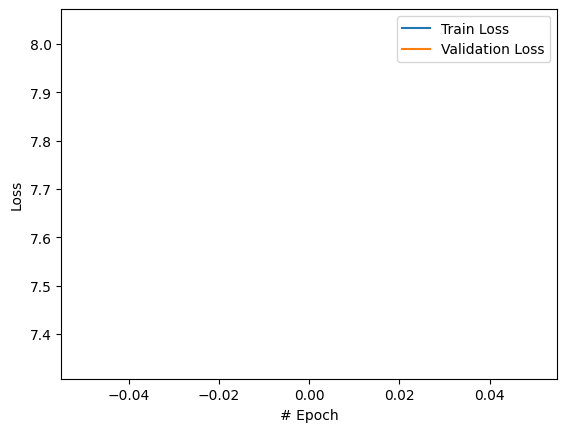

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 7.342514762650858 to 7.1218353062544875
Epoch:  2/50 | Training pTLoss:  7.5880939717406655 | Testing pTLoss:  7.1218353062544875


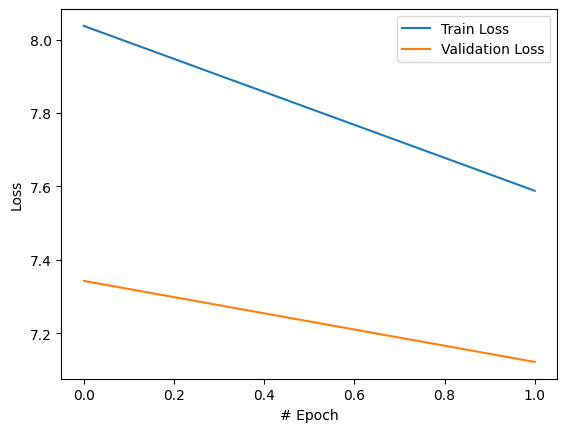

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 7.1218353062544875 to 6.853350942926141
Epoch:  3/50 | Training pTLoss:  7.322582871432941 | Testing pTLoss:  6.853350942926141


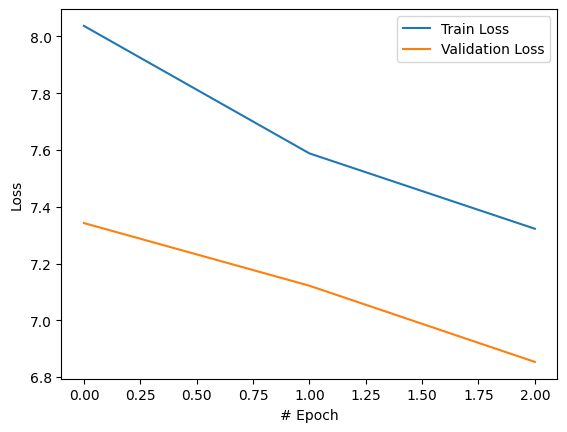

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 6.853350942926141 to 6.643836534462886
Epoch:  4/50 | Training pTLoss:  7.074068768681257 | Testing pTLoss:  6.643836534462886


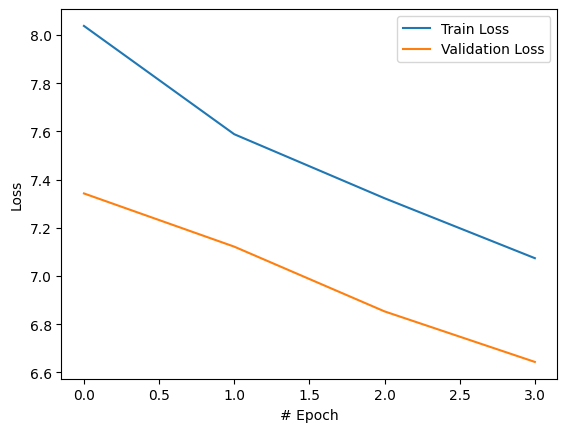

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 6.643836534462886 to 6.4743821533021055
Epoch:  5/50 | Training pTLoss:  6.832425160676945 | Testing pTLoss:  6.4743821533021055


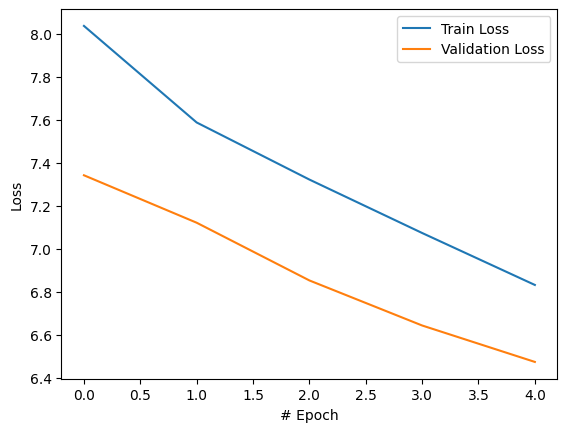

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 6.4743821533021055 to 6.210782722899299
Epoch:  6/50 | Training pTLoss:  6.567596905143554 | Testing pTLoss:  6.210782722899299


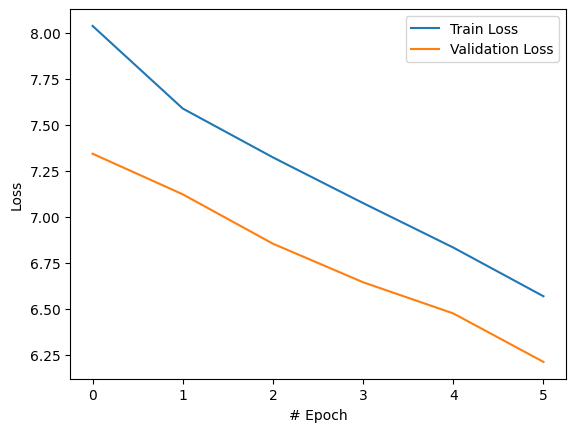

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 6.210782722899299 to 6.001399422933123
Epoch:  7/50 | Training pTLoss:  6.301857749190093 | Testing pTLoss:  6.001399422933123


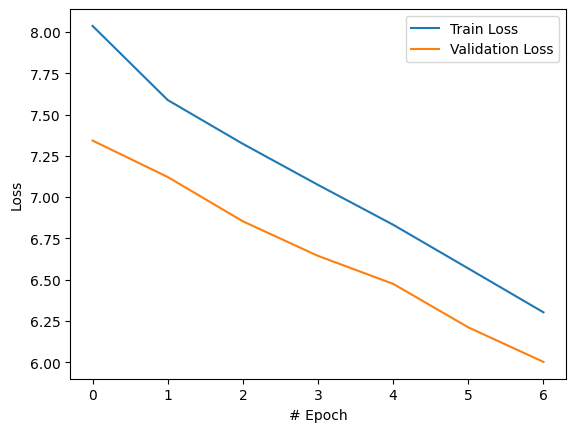

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 6.001399422933123 to 5.8854730165444336
Epoch:  8/50 | Training pTLoss:  6.175836599571327 | Testing pTLoss:  5.8854730165444336


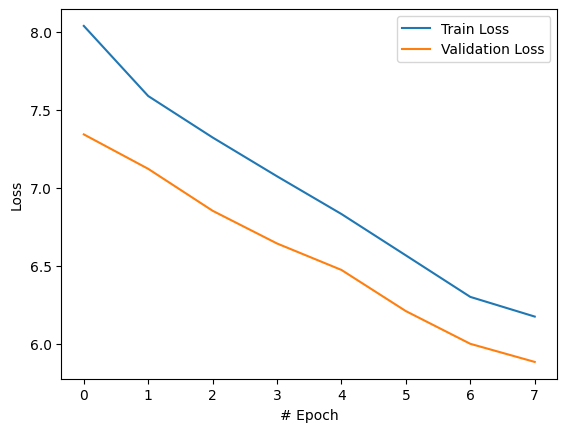

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 5.8854730165444336 to 5.836322429640432
Epoch:  9/50 | Training pTLoss:  6.099368870904803 | Testing pTLoss:  5.836322429640432


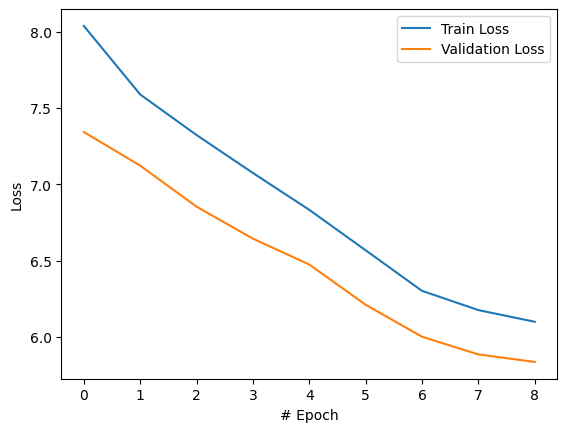

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 5.836322429640432 to 5.775376832407618
Epoch:  10/50 | Training pTLoss:  6.0429530991908 | Testing pTLoss:  5.775376832407618


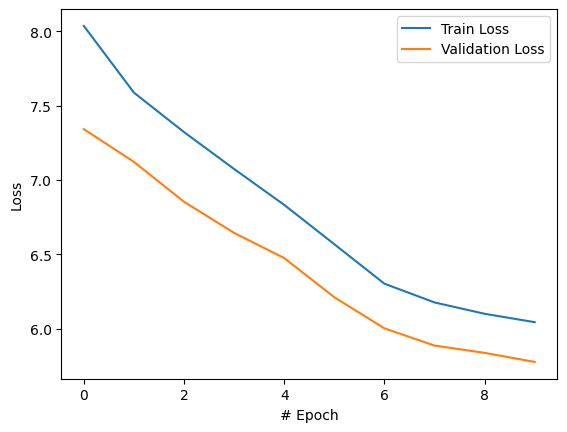

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 5.775376832407618 to 5.742744438560291
Epoch:  11/50 | Training pTLoss:  5.995317125010138 | Testing pTLoss:  5.742744438560291


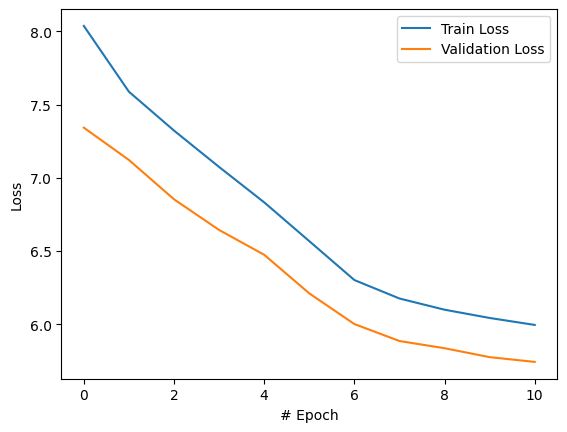

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 5.742744438560291 to 5.6989863689447455
Epoch:  12/50 | Training pTLoss:  5.956463107835177 | Testing pTLoss:  5.6989863689447455


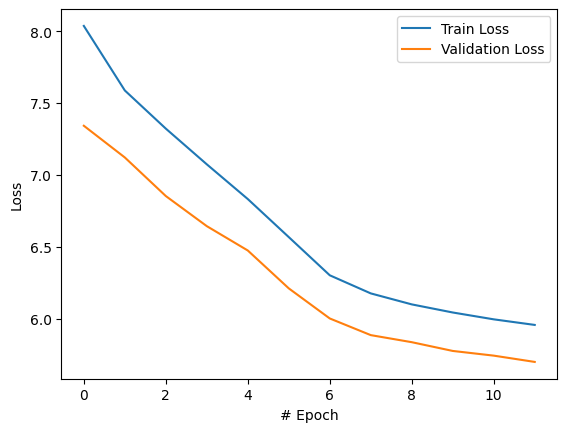

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 5.6989863689447455 to 5.668721480897084
Epoch:  13/50 | Training pTLoss:  5.917707706997555 | Testing pTLoss:  5.668721480897084


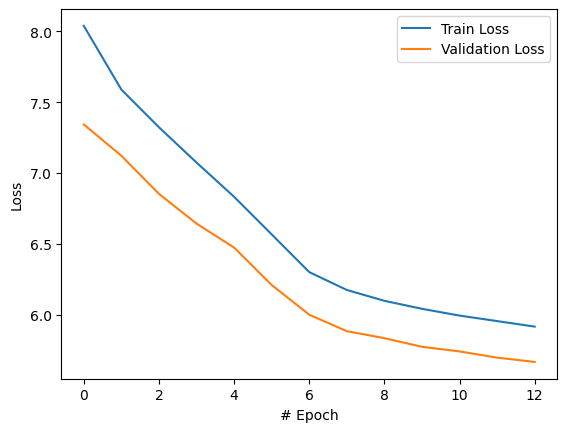

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 5.668721480897084 to 5.629236812963921
Epoch:  14/50 | Training pTLoss:  5.875270695851834 | Testing pTLoss:  5.629236812963921


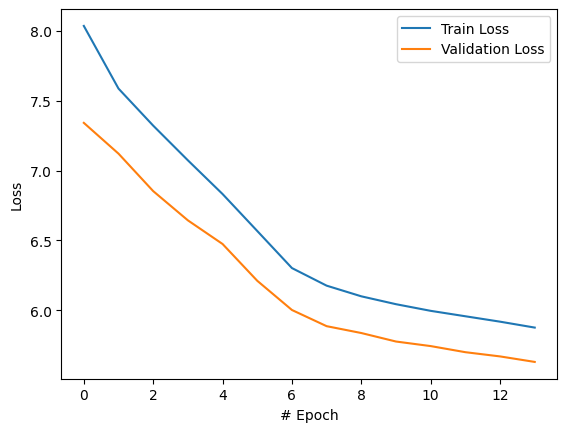

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 5.629236812963921 to 5.582062068057937
Epoch:  15/50 | Training pTLoss:  5.823433653134324 | Testing pTLoss:  5.582062068057937


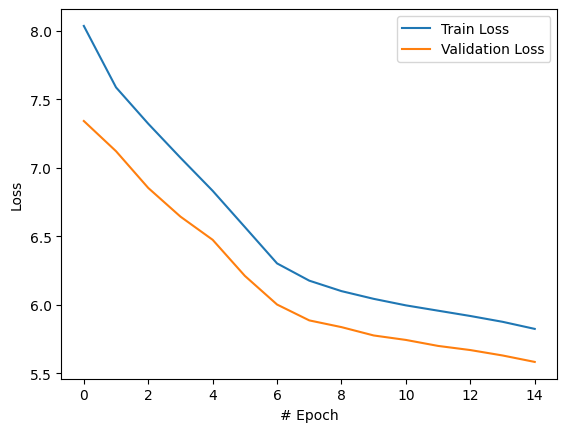

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 5.582062068057937 to 5.532900358746211
Epoch:  16/50 | Training pTLoss:  5.769964741781324 | Testing pTLoss:  5.532900358746211


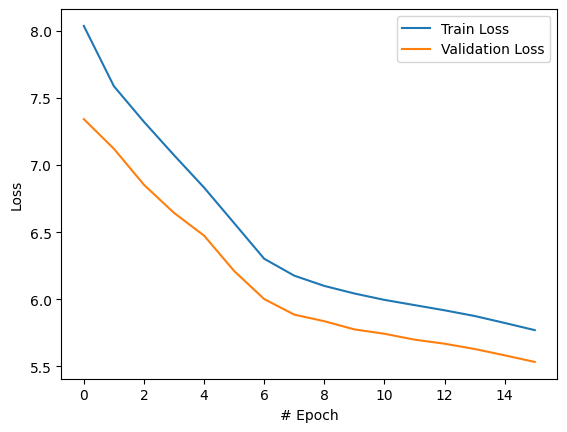

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 5.532900358746211 to 5.4657002421108105
Epoch:  17/50 | Training pTLoss:  5.711610321109056 | Testing pTLoss:  5.4657002421108105


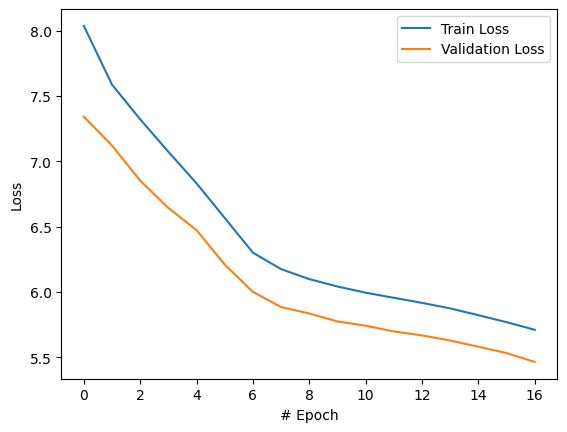

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 5.4657002421108105 to 5.439707732252345
Epoch:  18/50 | Training pTLoss:  5.6456609809217735 | Testing pTLoss:  5.439707732252345


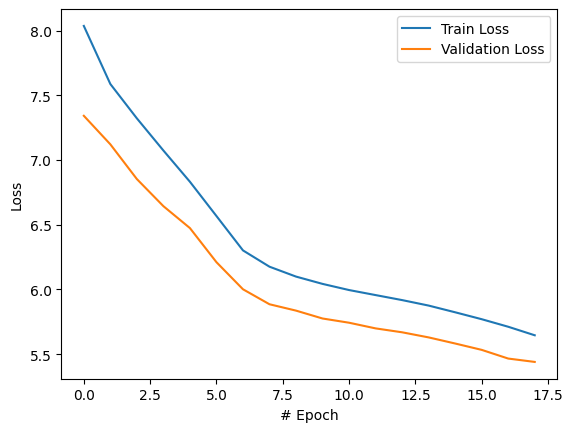

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 5.439707732252345 to 5.393414026227279
Epoch:  19/50 | Training pTLoss:  5.576815766264193 | Testing pTLoss:  5.393414026227279


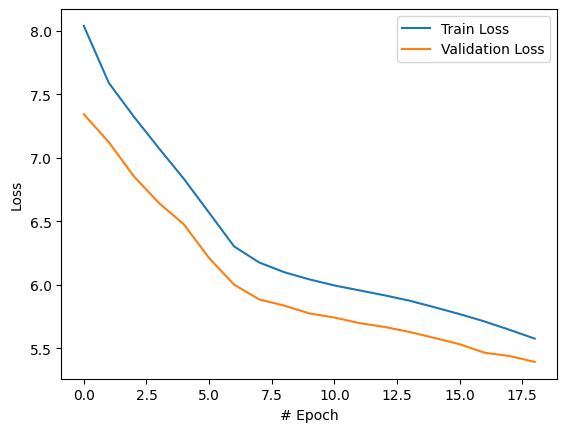

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 5.393414026227279 to 5.357543556395425
Epoch:  20/50 | Training pTLoss:  5.5028584189632115 | Testing pTLoss:  5.357543556395425


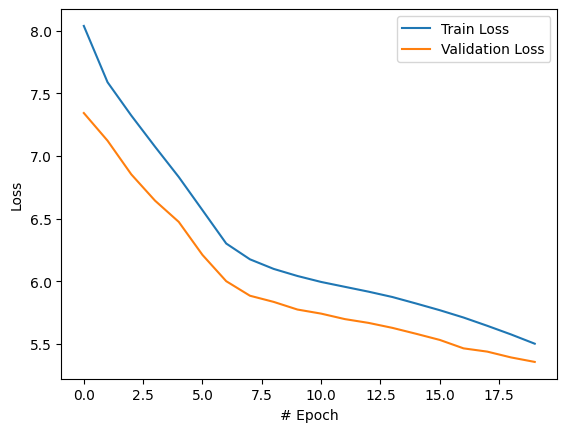

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 5.357543556395425 to 5.322863969006404
Epoch:  21/50 | Training pTLoss:  5.429538689311312 | Testing pTLoss:  5.322863969006404


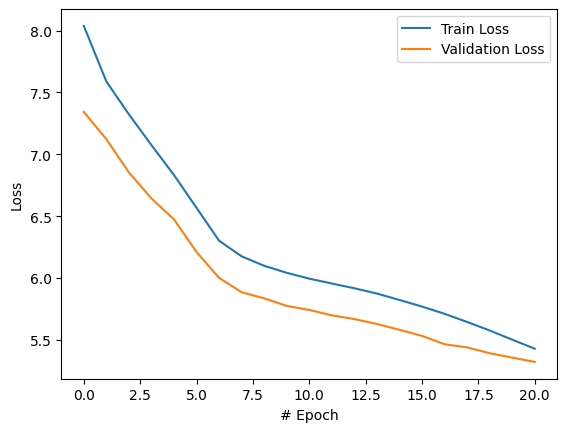

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 5.322863969006404 to 5.2803083665976
Epoch:  22/50 | Training pTLoss:  5.359815938095212 | Testing pTLoss:  5.2803083665976


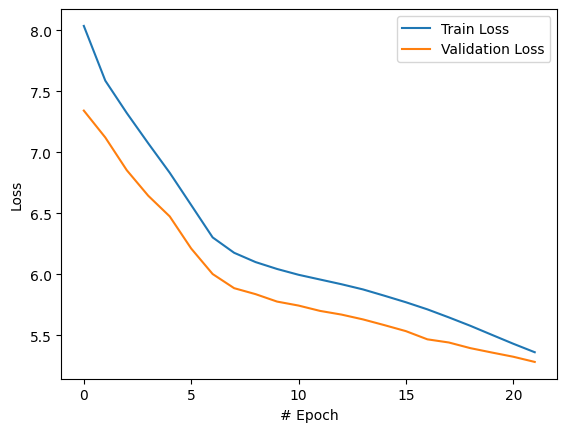

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 5.2803083665976 to 5.211958972337193
Epoch:  23/50 | Training pTLoss:  5.291955162025587 | Testing pTLoss:  5.211958972337193


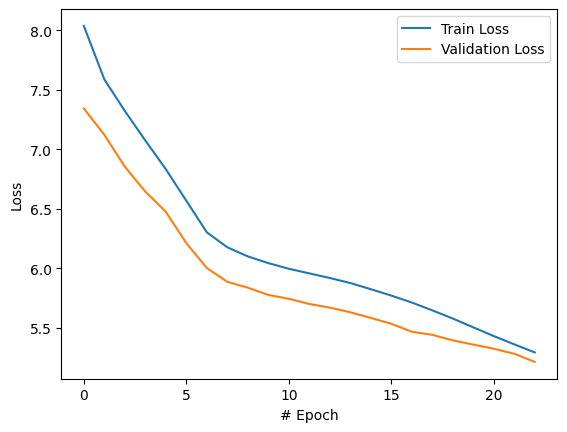

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 5.211958972337193 to 5.164752421823868
Epoch:  24/50 | Training pTLoss:  5.234643032649071 | Testing pTLoss:  5.164752421823868


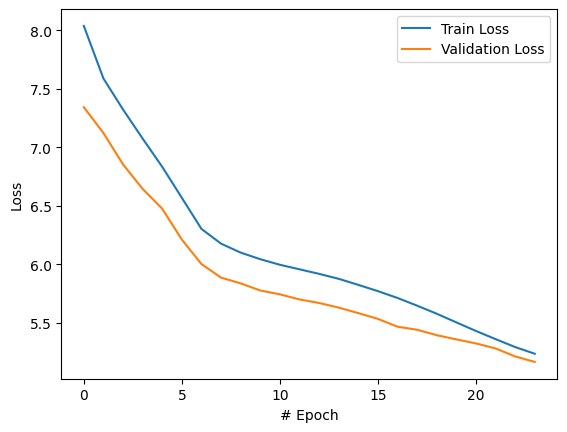

  0%|          | 0/922 [00:00<?, ?it/s]

Epoch:  25/50 | Training pTLoss:  5.171454615551581 | Testing pTLoss:  5.22821305604922


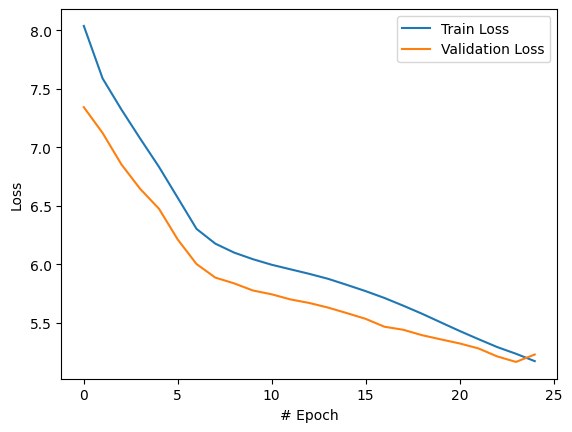

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 5.164752421823868 to 5.159945341097813
Epoch:  26/50 | Training pTLoss:  5.111989559941077 | Testing pTLoss:  5.159945341097813


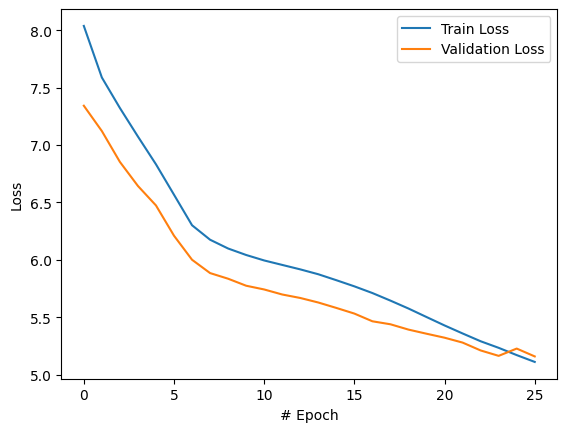

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 5.159945341097813 to 5.052334063740975
Epoch:  27/50 | Training pTLoss:  5.0667477243634425 | Testing pTLoss:  5.052334063740975


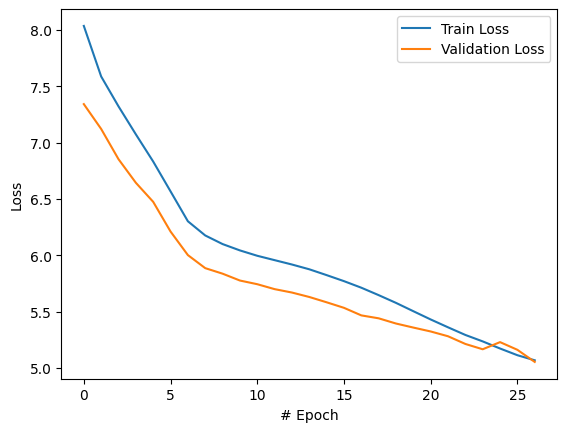

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 5.052334063740975 to 4.971481859813286
Epoch:  28/50 | Training pTLoss:  5.019575553447199 | Testing pTLoss:  4.971481859813286


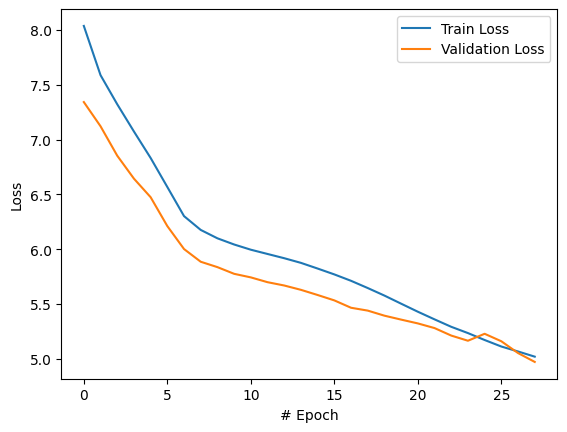

  0%|          | 0/922 [00:00<?, ?it/s]

Epoch:  29/50 | Training pTLoss:  4.971286359164311 | Testing pTLoss:  5.007998406757756


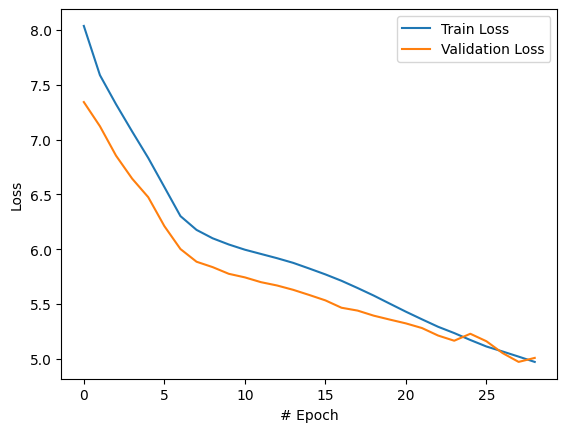

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 4.971481859813286 to 4.882301353839362
Epoch:  30/50 | Training pTLoss:  4.93046127560341 | Testing pTLoss:  4.882301353839362


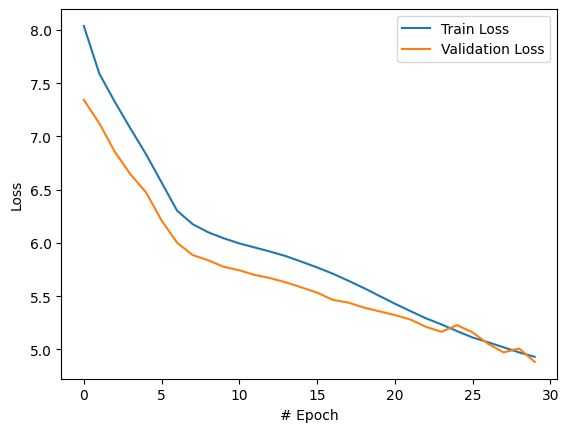

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 4.882301353839362 to 4.850057529782523
Epoch:  31/50 | Training pTLoss:  4.897780275137976 | Testing pTLoss:  4.850057529782523


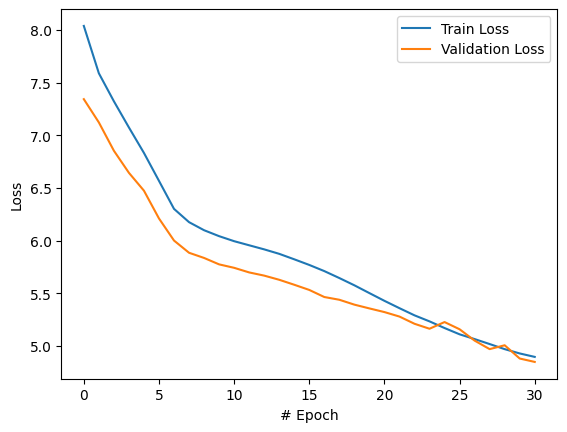

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 4.850057529782523 to 4.812383409953171
Epoch:  32/50 | Training pTLoss:  4.866828970174729 | Testing pTLoss:  4.812383409953171


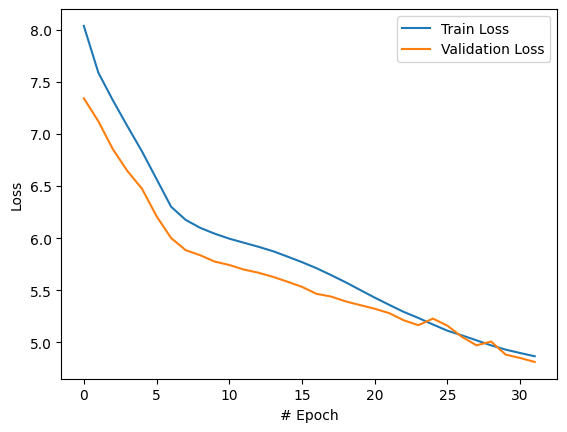

  0%|          | 0/922 [00:00<?, ?it/s]

Epoch:  33/50 | Training pTLoss:  4.8396512347550305 | Testing pTLoss:  4.8308729740130385


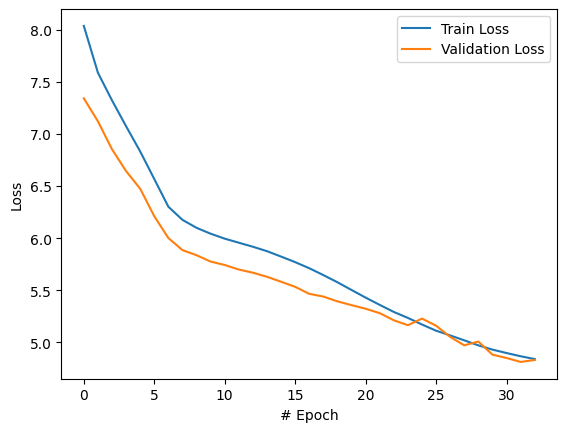

  0%|          | 0/922 [00:00<?, ?it/s]

Epoch 00034: reducing learning rate of group 0 to 5.0000e-04.
Epoch:  34/50 | Training pTLoss:  4.818508317827405 | Testing pTLoss:  4.8240577153166555


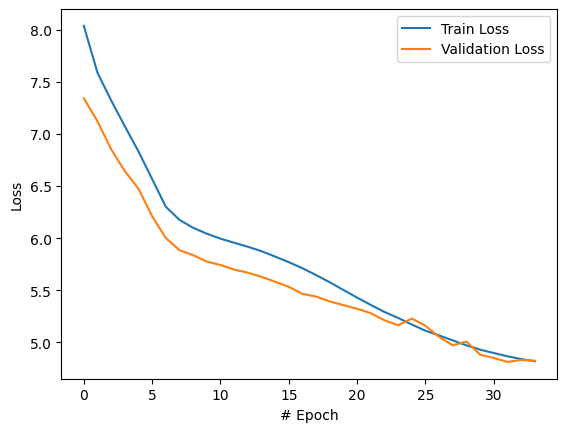

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 4.812383409953171 to 4.601751386472826
Epoch:  35/50 | Training pTLoss:  4.662856542495228 | Testing pTLoss:  4.601751386472826


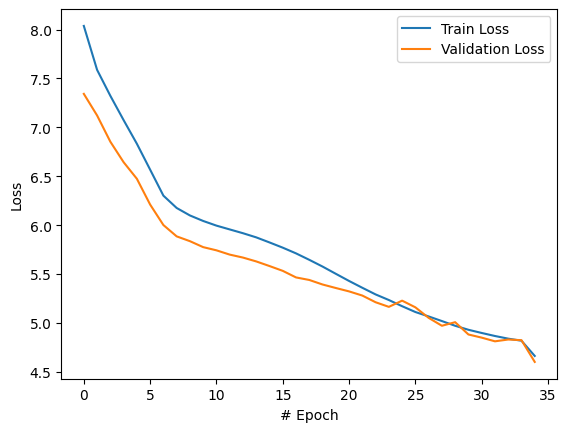

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 4.601751386472826 to 4.580303862141425
Epoch:  36/50 | Training pTLoss:  4.636196139965556 | Testing pTLoss:  4.580303862141425


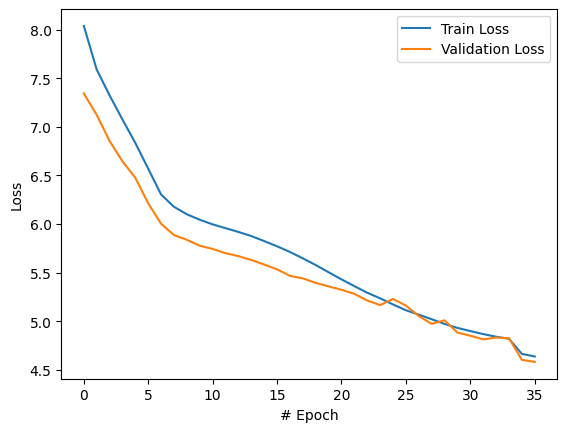

  0%|          | 0/922 [00:00<?, ?it/s]

Epoch:  37/50 | Training pTLoss:  4.617072204059223 | Testing pTLoss:  4.610855107969415


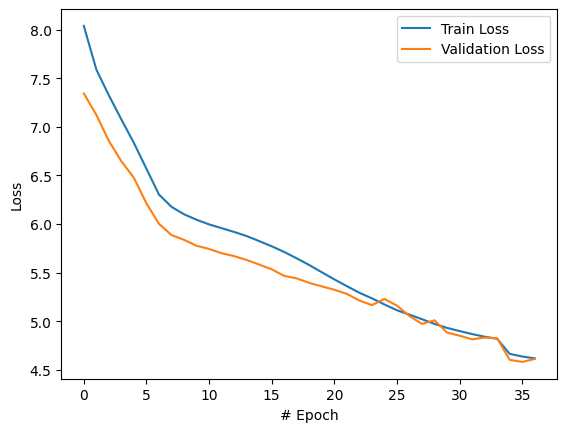

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 4.580303862141425 to 4.576003257468054
Epoch:  38/50 | Training pTLoss:  4.603187914267021 | Testing pTLoss:  4.576003257468054


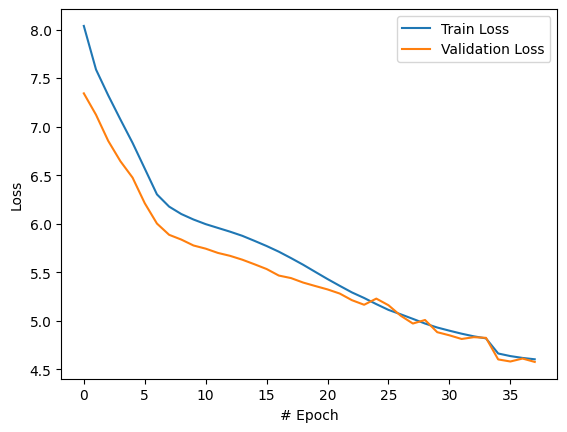

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 4.576003257468054 to 4.566305467208397
Epoch:  39/50 | Training pTLoss:  4.591439580322597 | Testing pTLoss:  4.566305467208397


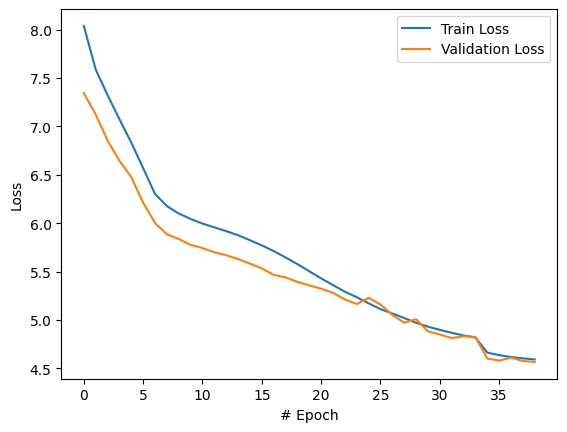

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 4.566305467208397 to 4.550479496120109
Epoch:  40/50 | Training pTLoss:  4.578970595450815 | Testing pTLoss:  4.550479496120109


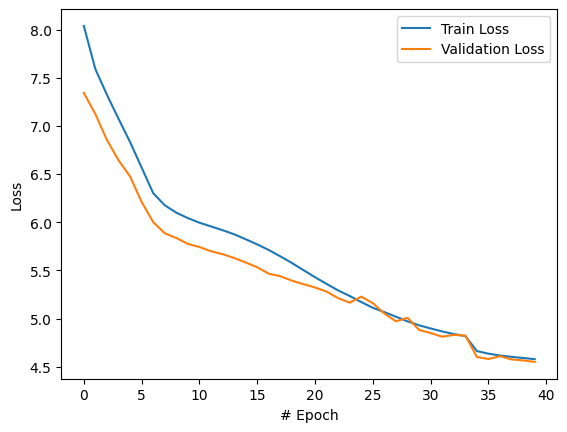

  0%|          | 0/922 [00:00<?, ?it/s]

Epoch:  41/50 | Training pTLoss:  4.570084658465527 | Testing pTLoss:  4.572569442415963


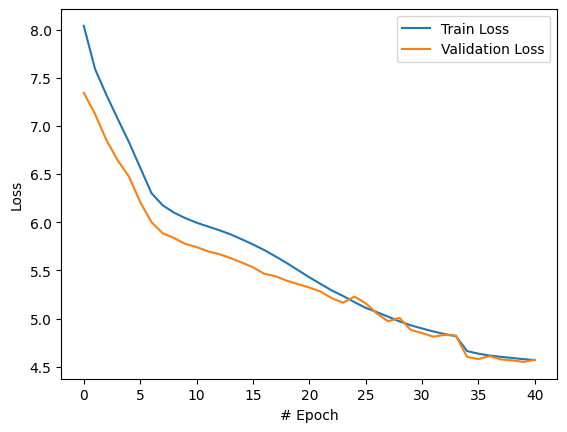

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 4.550479496120109 to 4.52103845364618
Epoch:  42/50 | Training pTLoss:  4.558518222381651 | Testing pTLoss:  4.52103845364618


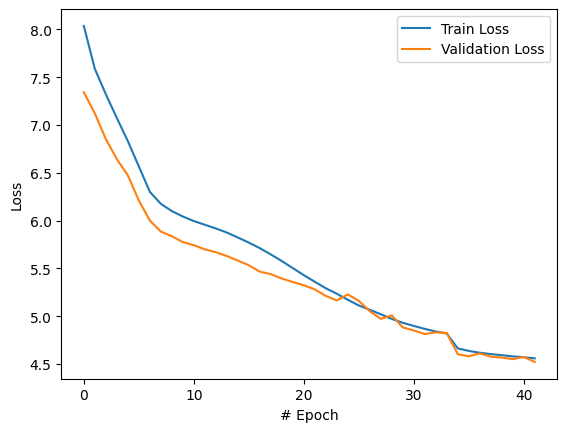

  0%|          | 0/922 [00:00<?, ?it/s]

Epoch:  43/50 | Training pTLoss:  4.550686618769762 | Testing pTLoss:  4.536916075973346


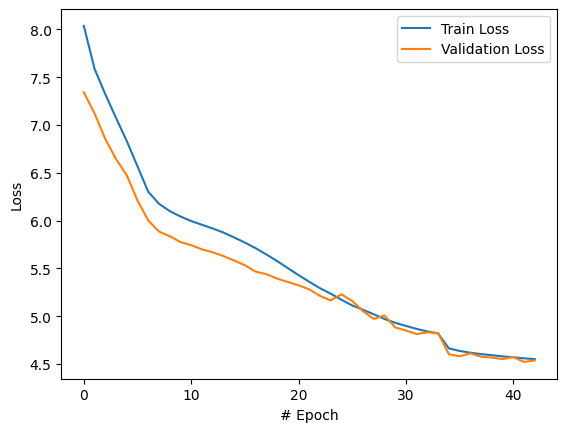

  0%|          | 0/922 [00:00<?, ?it/s]

Epoch 00044: reducing learning rate of group 0 to 2.5000e-04.
Epoch:  44/50 | Training pTLoss:  4.540347174941328 | Testing pTLoss:  4.541003096905293


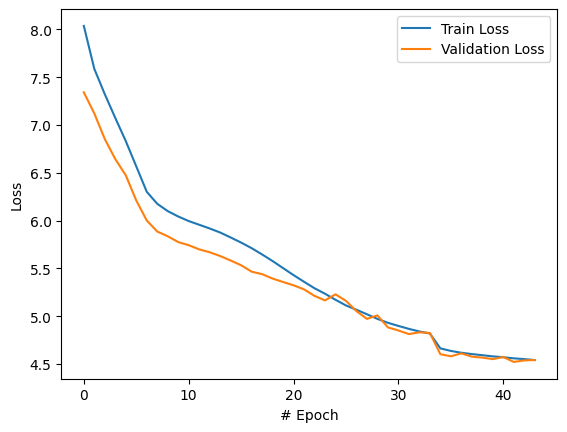

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 4.52103845364618 to 4.47519106513249
Epoch:  45/50 | Training pTLoss:  4.455636349262233 | Testing pTLoss:  4.47519106513249


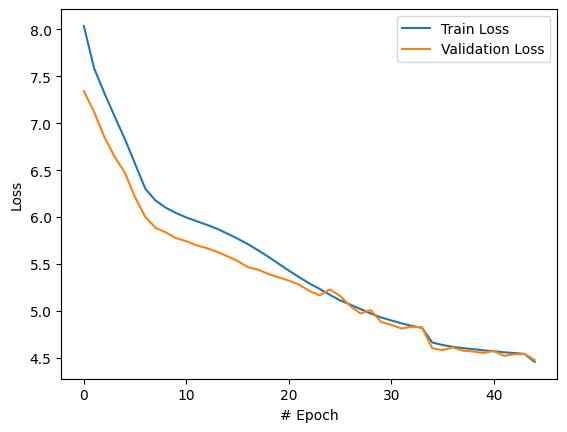

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 4.47519106513249 to 4.47121138350307
Epoch:  46/50 | Training pTLoss:  4.443899922412285 | Testing pTLoss:  4.47121138350307


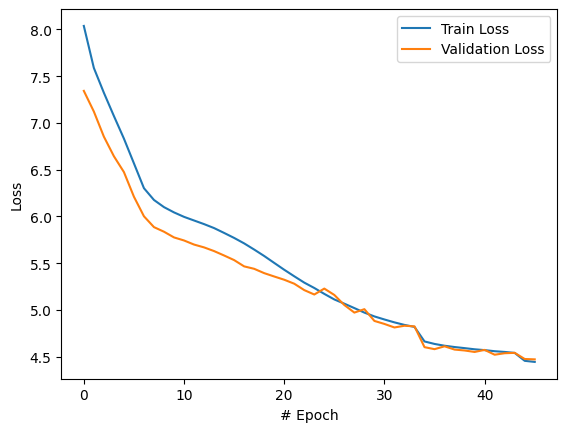

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 4.47121138350307 to 4.4618610435866435
Epoch:  47/50 | Training pTLoss:  4.4362231675301045 | Testing pTLoss:  4.4618610435866435


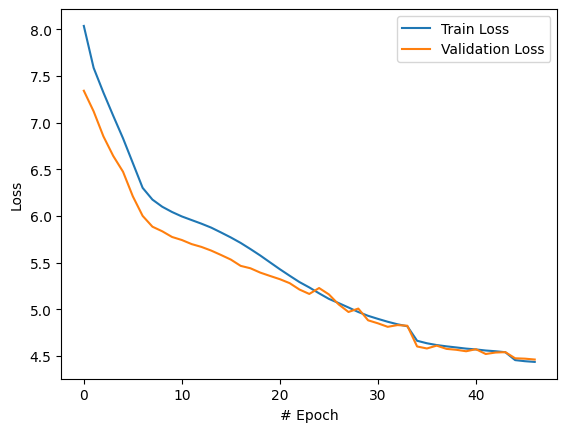

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 4.4618610435866435 to 4.457520354854312
Epoch:  48/50 | Training pTLoss:  4.430631087167658 | Testing pTLoss:  4.457520354854312


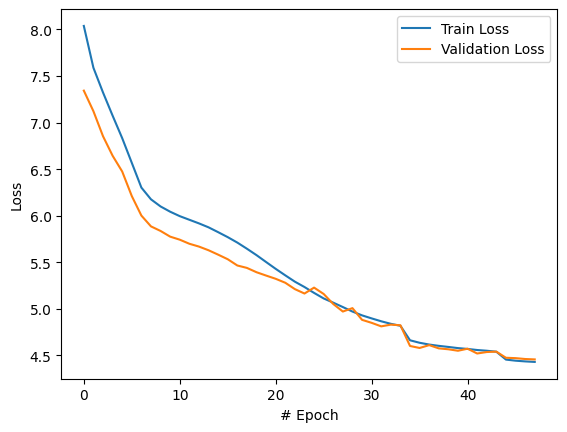

  0%|          | 0/922 [00:00<?, ?it/s]

Epoch:  49/50 | Training pTLoss:  4.425416151510138 | Testing pTLoss:  4.459493520202967


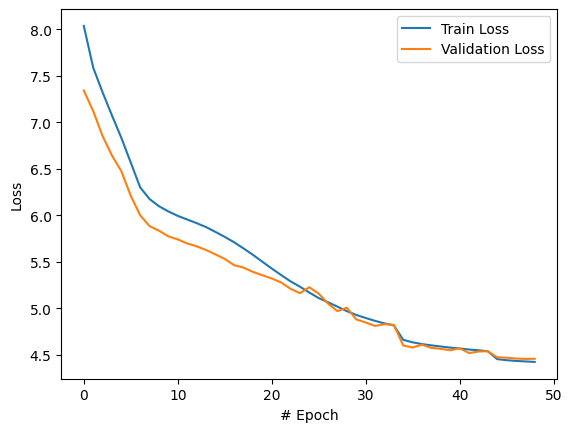

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 4.457520354854312 to 4.452193300791265
Epoch:  50/50 | Training pTLoss:  4.420298689358151 | Testing pTLoss:  4.452193300791265


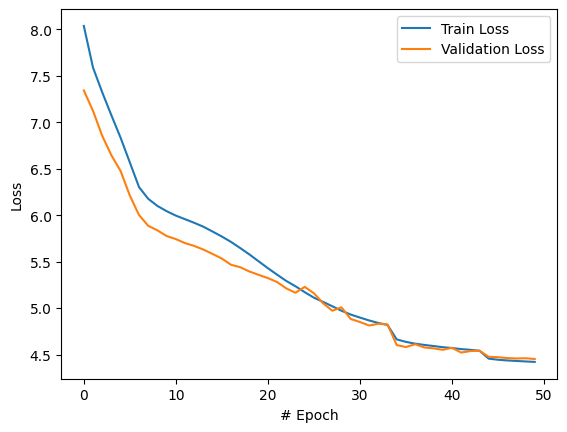

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

epochs = 50
model = MODEL_GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.002, weight_decay=5e-4)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=1, factor=0.5)

model_name = f'/kaggle/working/model_trained/{name}_loss' + 'no_inv_' + '.pth'
os.makedirs("/kaggle/working/model_trained" , exist_ok =True)
train_losses, test_losses = train(train_loader, test_loader, prog_bar=True)

# TESTING

## Metrics

In [30]:
def f1_comp(y_true,y_pred):
    f1 = []
    for i in range(100): 
        grnd = y_true >= i
        pred = y_pred >= i
        f1.append(sklearn.metrics.f1_score(grnd,pred))
    return f1

def acc_comp(y_true,y_pred):
    acc = []
    for i in range(100):
        grnd = y_true >= i
        pred = y_pred >= i
        cmp = np.sum(np.equal(grnd,np.squeeze(pred))) 
        acc.append(cmp/len(grnd)*100)
    return acc

In [31]:
# model_name = f'/kaggle/working/model_trained/{name}_loss' + 'no_inv_' + '.pth'
model_name = "/kaggle/input/converting-to-graphs-eachfeature-node/model_trained/4GCN_Conv_7nodes_lossno_inv_.pth"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loaded_model = MODEL_GNN().to(device)
loaded_model.load_state_dict(torch.load(model_name))

<All keys matched successfully>

In [32]:
import numpy as np
import sklearn.metrics
import torch
from torch.utils.data import DataLoader

In [33]:
y_true_all = []
y_pred_all = []
# Assuming you have a test_loader and a model
test_los = 0
loaded_model.eval()
with torch.no_grad():
    for data in tqdm(test_loader, position=0):
        data = data.to(device)
        out = loaded_model(data)
#         preds.append(out.cpu().detach())
        
        # Collect true labels and predictions
        labels = data.y.cpu().numpy()
        y_true_all.extend(labels)
        y_pred_all.extend(out.cpu().detach().numpy())
        
        loss = pTLossTorch(out, data.y)
        test_los += loss.cpu().detach().numpy() / len(test_loader)

# Convert collected labels and predictions to numpy arrays
y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)

# Calculate F1 scores and accuracy
f1_scores = f1_comp(y_true_all, y_pred_all)
accuracy_scores = acc_comp(y_true_all, y_pred_all)

# Calculate MAE
mae = sklearn.metrics.mean_absolute_error(y_true_all, y_pred_all)

  0%|          | 0/461 [00:00<?, ?it/s]

In [34]:
# Print results
print('Test_loss:', test_los)
print("F1 Scores:", f1_scores[-1])
print("Accuracy Scores:", accuracy_scores[-1])
print("Mean Absolute Error (MAE):", mae)

Test_loss: 4.387854209432376
F1 Scores: 0.1488533102553007
Accuracy Scores: 80.81968186134853
Mean Absolute Error (MAE): 45.339565


In [35]:
import csv

# Data to be saved
results = {
    'Test_loss': test_los,
    'F1_Score': f1_scores[-1],
    'Accuracy_Score': accuracy_scores[-1],
    'MAE': mae
}

# Save to CSV
with open('evaluation_results.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Metric', 'Value'])
    for key, value in results.items():
        writer.writerow([key, value])

print('Results saved to evaluation_results.csv')

Results saved to evaluation_results.csv
